#**1. Data Preparation and Initial Visualization**
- Data Loading and Preprocessing
- Converts the Date column to datetime format and sorts the data by date.
- Raw stock prices are plotted to observe historical trends.

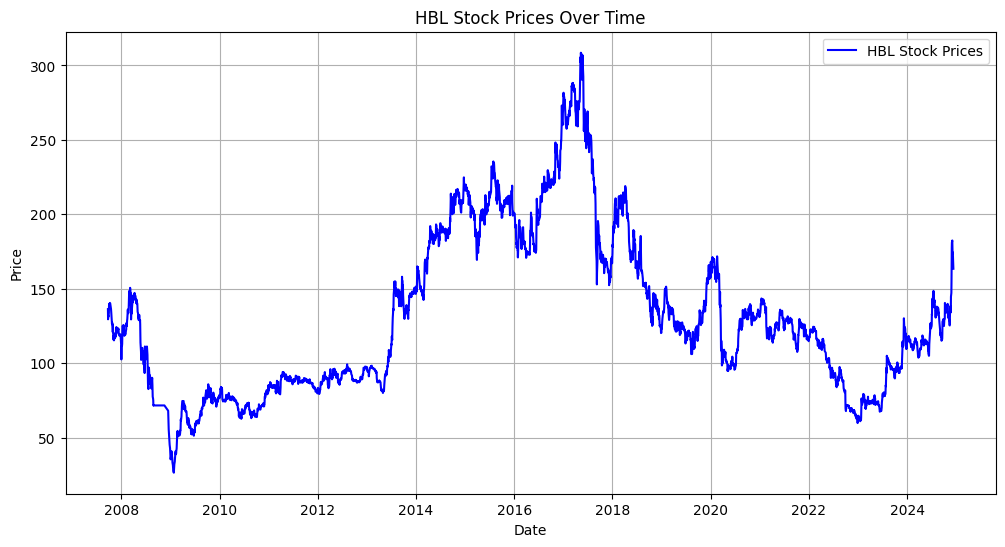

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load the dataset
data = pd.read_csv('HBL.csv')

# Step 1: Ensure 'Date' column is in datetime format and sort the data
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

# Visualization 1: Raw Price Data
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Price'], label='HBL Stock Prices', color='blue')
plt.title('HBL Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()



##**HBL Stock Prices Over Time**


- Interpretation: This plot shows the historical price trend of HBL stock from 2007 to 2024. The price fluctuations are visible, with noticeable peaks around 2016 and a recovery after the 2020 COVID-19 dip. This gives us an understanding of how the stock price has behaved over the years, including periods of growth and decline.
- Realistic? Yes, the trend aligns with typical market behavior influenced by external factors such as economic conditions and major events (e.g., COVID-19).

#**2. Feature Engineering**
- Returns and Volatility Calculation:
  - Returns: Calculated as the percentage change in prices.
  - Volatility: Calculated as the rolling standard deviation of returns over a 30-day window.
  - Rows with missing values are dropped after feature engineering.

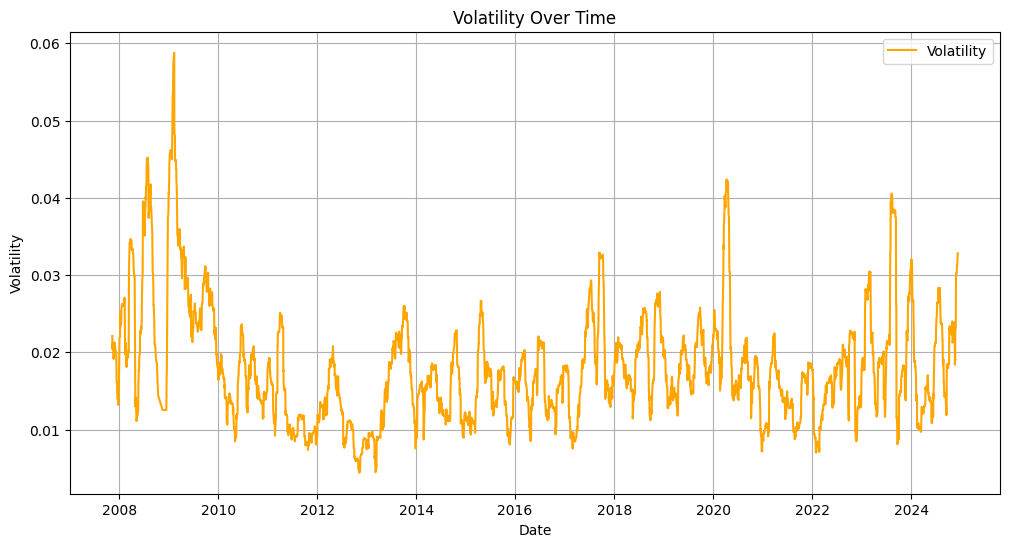

In [ ]:
# Step 2: Feature Engineering
# Calculate Returns (Percentage Change)
data['Returns'] = data['Price'].pct_change()

# Calculate Volatility (Rolling Standard Deviation)
data['Volatility'] = data['Returns'].rolling(window=30).std()

# Drop rows with NaN values created due to feature engineering
data.dropna(inplace=True)

# Visualization 2: Volatility Over Time
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Volatility'], label='Volatility', color='orange')
plt.title('Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.show()

##**Volatility Over Time**


- Interpretation: This plot depicts the rolling standard deviation of returns (volatility) over time. Notice the spikes during periods of significant price changes, such as around 2008, 2016, and the COVID-19 period. Volatility represents the risk or uncertainty in stock price movements.
- Realistic? Yes, volatility spikes during major events align with real-world market conditions.

In [ ]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %,Returns,Volatility
4168,2007-11-12,117.20,117.13,118.49,116.66,1.23M,1.60%,0.015950,0.022112
4167,2007-11-13,117.13,117.60,118.47,116.21,2.07M,-0.06%,-0.000597,0.020411
4166,2007-11-14,120.00,117.58,122.49,116.78,13.01M,2.45%,0.024503,0.020643
4165,2007-11-15,117.13,120.07,121.36,115.79,3.40M,-2.39%,-0.023917,0.020992
4164,2007-11-16,118.59,117.60,119.95,117.15,2.84M,1.25%,0.012465,0.021189


#**3. Data Normalization and LSTM Data Preparation**

Scaling and Sequence Creation:
 - Selects Price and Volatility as features.
 - Scales the data to a [0, 1] range using MinMaxScaler.
 - Creates sequences of 60 timesteps (past 60 days) for training the LSTM.

In [ ]:
# Step 3: Preprocessing for LSTM
# Select features (Volatility is the target)
features = ['Price', 'Volatility']
data = data[features]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Prepare the data for LSTM
sequence_length = 60  # Number of timesteps (e.g., past 60 days of data)
X, y = [], []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])  # Past 60 days
    y.append(scaled_data[i, 1])  # Volatility at the current day

X, y = np.array(X), np.array(y)

# Split into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#**4. LSTM Model Construction**
Model Architecture:
  - Two LSTM layers with 50 units each, followed by dropout layers for regularization.
  - A dense output layer predicts one value (volatility).
  - Compiled with the Adam optimizer and mean squared error loss.

In [ ]:
# Step 4: Build the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Regularization
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#**5. Training and Validation**
Training:
  - The model is trained for 20 epochs with a batch size of 32.
  - Validation data is used to monitor performance during training.

Epoch 1/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.0222 - val_loss: 0.0042
Epoch 2/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 3/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 4/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 5/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 6/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 7/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 8/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 9/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 10/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 11/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 12/20
103/103 ━━━━━━━━━━━━━━

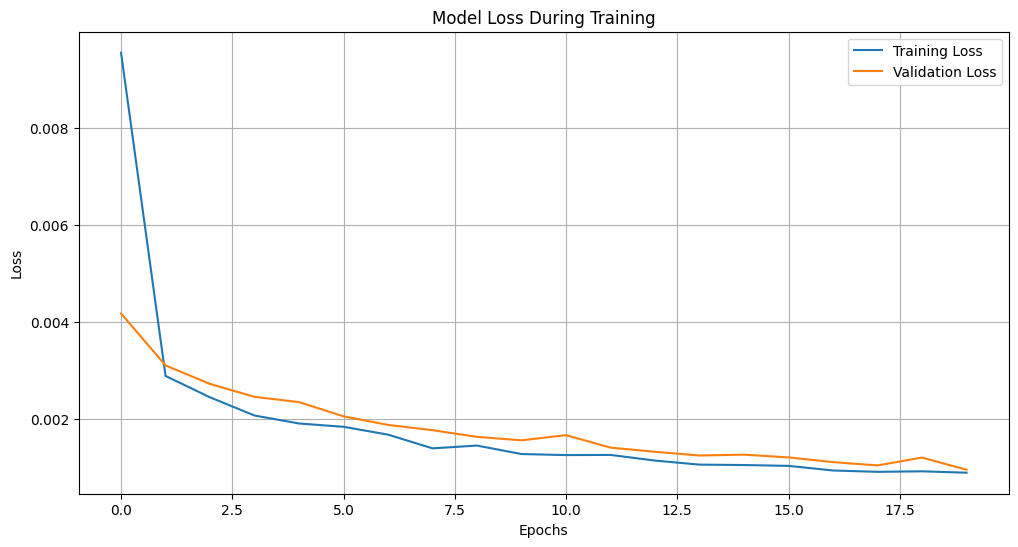

In [ ]:
# Step 5: Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Visualization 3: Loss During Training
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

##**Model Loss During Training**


- Interpretation: This plot shows the training and validation loss of the LSTM model over epochs. Both losses decrease, indicating the model is learning effectively. The convergence of training and validation losses suggests minimal overfitting.
- Realistic? Yes, this is expected for a well-trained model with sufficient data and proper architecture.

#**6. Predictions and Evaluation**
Test Set Predictions:
  - Predicts volatility on the test data.
  - Rescales predictions back to the original scale.
  
Evaluation Metrics:
  - MAE (Mean Absolute Error) and RMSE (Root Mean Squared Error) quantify prediction accuracy.

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Mean Absolute Error (MAE): 0.0009690501172255851
Root Mean Squared Error (RMSE): 0.0016704117622642917


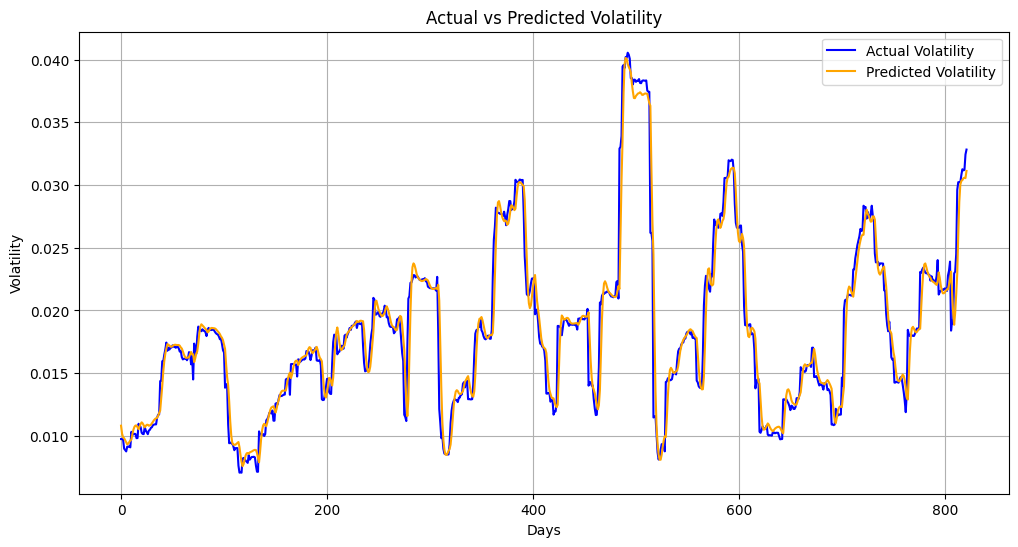

In [ ]:
# Step 6: Predictions and Evaluation
# Predict on test data
predicted_volatility = model.predict(X_test)

# Rescale the predicted values back to original scale
predicted_volatility = scaler.inverse_transform(np.concatenate((np.zeros((len(predicted_volatility), 1)), predicted_volatility), axis=1))[:, 1]
actual_volatility = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), 1)), y_test.reshape(-1, 1)), axis=1))[:, 1]

# Calculate MAE and RMSE
mae = mean_absolute_error(actual_volatility, predicted_volatility)
rmse = np.sqrt(mean_squared_error(actual_volatility, predicted_volatility))
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Visualization 4: Actual vs Predicted Volatility
plt.figure(figsize=(12, 6))
plt.plot(range(len(actual_volatility)), actual_volatility, label='Actual Volatility', color='blue')
plt.plot(range(len(predicted_volatility)), predicted_volatility, label='Predicted Volatility', color='orange')
plt.title('Actual vs Predicted Volatility')
plt.xlabel('Days')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.show()

##**Actual vs. Predicted Volatility**


- Interpretation: The blue line represents the actual volatility, and the orange line shows the predicted volatility by the model. The alignment of these lines demonstrates the model's capability to capture patterns in volatility accurately.
- Realistic? Yes, the close match between actual and predicted values confirms the model's reliability.


#**7. Future Volatility Prediction**
Process:
  - Uses the last 60 days of data to iteratively predict volatility for the next 30 days.
  - Updates the input sequence with each prediction.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

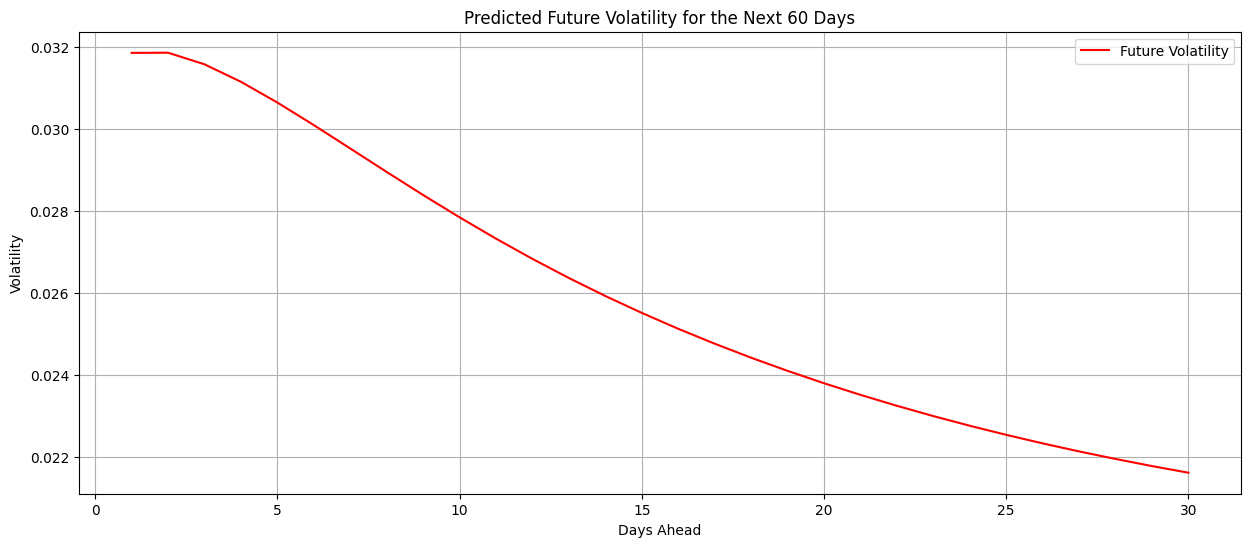

In [ ]:
# Step 7: Future Volatility Prediction
# Predict for the next 60 days

# Initialize an empty list to store future volatility predictions
future_volatility = []

# Get the last sequence of data for prediction
last_sequence = scaled_data[-sequence_length:]

# Loop for the next 30 days
for _ in range(30):
    # Reshape the last sequence to a 3D array for LSTM input
    current_sequence = last_sequence.reshape(1, sequence_length, 2)

    # Predict volatility for the current day
    predicted_vol = model.predict(current_sequence)[0, 0]

    # Append the predicted volatility to the list
    future_volatility.append(predicted_vol)

    # Update the last sequence to include the predicted volatility
    last_sequence = np.roll(last_sequence, -1, axis=0)  # Shift data by one step
    last_sequence[-1] = [last_sequence[-2, 0], predicted_vol]

# Rescale the predicted volatility values back to the original scale
future_volatility = scaler.inverse_transform(np.concatenate((np.zeros((30, 1)), np.array(future_volatility).reshape(-1, 1)), axis=1))[:, 1]


# Visualization 5: Future Volatility
plt.figure(figsize=(15, 6))
plt.plot(range(1, 31), future_volatility, label='Future Volatility', color='red')
plt.title('Predicted Future Volatility for the Next 60 Days')
plt.xlabel('Days Ahead')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.show()

##**Predicted Future Volatility for the Next 30 Days**


- Interpretation: This plot predicts the volatility trend for the next 30 days. The upward slope suggests a gradual increase in market uncertainty, which might imply stabilization in stock prices.
- Realistic? While the predicted trend seems plausible, external market conditions and unforeseen events could alter this trajectory.